# Continuous-time Controlled Invariant Set


## Introduction

This capsule reproduces the result of the Section 4 of [LJ21].

This example considers the continuous-time constrained linear control system:
$$
\begin{align*}
\dot{x}_1(t) & = x_2(t)\\
\dot{x}_2(t) & = u(t)
\end{align*}
$$
with state constraint $x \in [-1, 1]^2$ and input constraint $u \in [-1, 1]$.

In order to compute controlled invariant sets for this system, we consider
the projection onto the first two dimensions of controlled invariant sets of the
following lifted system:
$$
\begin{align*}
\dot{x}_1(t) & = x_2(t)\\
\dot{x}_2(t) & = x_3(t)\\
\dot{x}_3(t) & = u(t)
\end{align*}
$$
with state constraint $x \in [-1, 1]^3$.

$\dot{x}(t) = Ax(t) + Bu(t)$
$$
A = \begin{bmatrix}
0 & 1\\
0 & 0
\end{bmatrix}.
$$
As shown in [LTJ18], a set $S$ is controlled invariant if
$$
\begin{bmatrix}
1 & \Delta t
\end{bmatrix}
S \subseteq
\begin{bmatrix}
1 & 0
\end{bmatrix}
S
$$

[LJ21] B. Legat and R. M. Jungers.
*Continuous-time controlled invariant sets, a geometric approach*.
7th IFAC Conference on Analysis and Design of Hybrid Systems ADHS 2021, **2021**.

The goal is to take the state vector toward a target set **XT** by visiting one of the squares
**A** or **B** and avoiding the obstacles **O1** and **O2**

The matricial form of this system is given by $\dot{x}(t) = Ax(t) + Bu(t)$ where `A` and `B` are as defined below.
As shown in Proposition 5 of [LJ21], a set is controlled invariant for this system if and only if it is invariant for the algebraic system
$$
\begin{align*}
\dot{x}_1(t) & = x_2(t)\\
\dot{x}_2(t) & = x_3(t)
\end{align*}
$$
The matricial form of this system is given by $E\dot{x}(t) = Cx(t)$ where

In [1]:
A = [0.0 1.0 0.0
     0.0 0.0 1.0
     0.0 0.0 0.0]
B = reshape([0.0, 0.0, 1.0], 3, 1)
E = [1.0 0.0 0.0
     0.0 1.0 0.0]
C = A[1:2, :]

2×3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.0  1.0

The invariance of a set $S$ for this system is characterized by the following condition (see Proposition 7 of [LJ21]):
$$
\forall x \in \partial S, \exists y \in T_S(x), Ey = Cx.
$$
The search for a set satisfying this condition can be formulated as the following set program; see [L20] for an intoduction to set programming.

[L20] Legat, B. (2020). *Set programming : theory and computation*. Ph.D. thesis, UCLouvain.

In [2]:
using SetProg
function maximal_invariant(family, γ = nothing; dirs=dirs)
    model = Model(sdp_solver)
    @variable(model, S, family)
    @constraint(model, S ⊆ □_3)
    x = boundary_point(S, :x)
    @constraint(model, C * x in E * tangent_cone(S, x))
    S_2 = project(S, 1:2)
    if γ === nothing
        @variable(model, γ)
    end
    for point in dirs
        @constraint(model, γ * point in S_2)
    end
    @show γ
    @objective(model, Max, γ)
    @show JuMP.objective_function(model)
    JuMP.optimize!(model)
    @show solve_time(model)
    @show JuMP.termination_status(model)
    @show JuMP.objective_value(model)
    if JuMP.termination_status(model) == MOI.OPTIMAL
        return JuMP.value(S), JuMP.objective_value(model)
    else
        return
    end
end

import GLPK
lp_solver = optimizer_with_attributes(GLPK.Optimizer, MOI.Silent() => true, "presolve" => GLPK.GLP_ON)
import CSDP
sdp_solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
using Polyhedra
interval = HalfSpace([1.0], 1.0) ∩ HalfSpace([-1.0], 1.0)
lib = Polyhedra.DefaultLibrary{Float64}(lp_solver)
□_2 = polyhedron(interval * interval, lib)
□_3 = □_2 * interval
dirs = [[-1 + √3, -1 + √3], [-1, 1]]
all_dirs = [dirs; (-).(dirs)]
inner = polyhedron(vrep(all_dirs), lib)
outer = polar(inner)

Polyhedron DefaultPolyhedron{Float64,Polyhedra.Intersection{Float64,Array{Float64,1},Int64},Polyhedra.Hull{Float64,Array{Float64,1},Int64}}:
4-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([0.7320508075688772, 0.7320508075688772], 1.0)
 HalfSpace([-1.0, 1.0], 1.0)
 HalfSpace([-0.7320508075688772, -0.7320508075688772], 1.0)
 HalfSpace([1.0, -1.0], 1.0)

## Ellipsoidal template

We start with the ellipsoidal template. We consider two different objectives (see Section 4.2 of [L20]):
* the volume of the set (which corresponds to $\log(\det(Q))$ or $\sqrt[n]{\det(Q)}$ in the objective function) and
* the sum of the squares of the length of its semi-axes of the polar (which corresponds to the trace of $Q$ in the objective function).

In [3]:
sol_ell, γ_ell = maximal_invariant(Ellipsoid(symmetric=true))

using Plots
function hexcolor(rgb::UInt32)
    r = ((0xff0000 & rgb) >> 16) / 255
    g = ((0x00ff00 & rgb) >>  8) / 255
    b = ((0x0000ff & rgb)      ) / 255
    Plots.RGBA(r, g, b)
end

γ = γ
JuMP.objective_function(model) = γ
solve_time(model) = 0.2754068374633789
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.objective_value(model) = 0.8068982210085237


hexcolor (generic function with 1 method)

Values taken from http://www.toutes-les-couleurs.com/code-couleur-rvb.php

In [4]:
lichen = hexcolor(0x85c17e)
canard = hexcolor(0x048b9a)
aurore = hexcolor(0xffcb60)
frambo = hexcolor(0xc72c48)
cols = [canard, frambo]

x2 = range(0, stop=1, length=20)
x1 = 1 .- x2.^2 / 2
upper = [[[-1, 1]]; [[x1[i], x2[i]] for i in eachindex(x2)]]
mci = polyhedron(vrep([upper; (-).(upper)]), lib)
polar_mci = polar(mci)

function _print_gauge_function(ell::SetProg.Sets.Ellipsoid, x)
    print(" ")
    println(x' * round.(ell.Q, digits=3) * x)
end
function print_support_function(set::SetProg.Sets.Polar)
    SetProg.@polyvar x[1:SetProg.Sets.dimension(set)]
    print("h(S, x) =")
    _print_gauge_function(polar(set), x)
end
print_support_function(project(sol_ell, 1:2))

h(S, x) = x[1]^2 - 0.604*x[1]*x[2] + x[2]^2


We can plot the primal solution as follows:

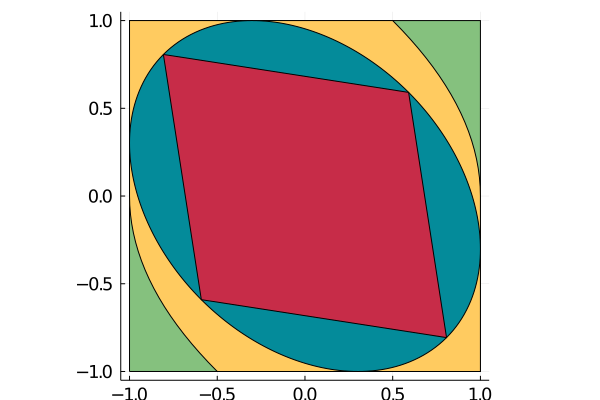

In [5]:
function primal_plot(set, γ=nothing; npoints=256, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05), args...)
    plot(ratio=:equal, tickfont=Plots.font(12); xlim=xlim, ylim=ylim, args...)
    plot!(□_2, color=lichen)
    plot!(mci, color=aurore)
    plot!(set, color=canard, npoints=npoints)
    γ === nothing || plot!(γ * inner, color=frambo)
    plot!()
end
primal_plot(project(sol_ell, 1:2), γ_ell)

and the dual plot as follows:

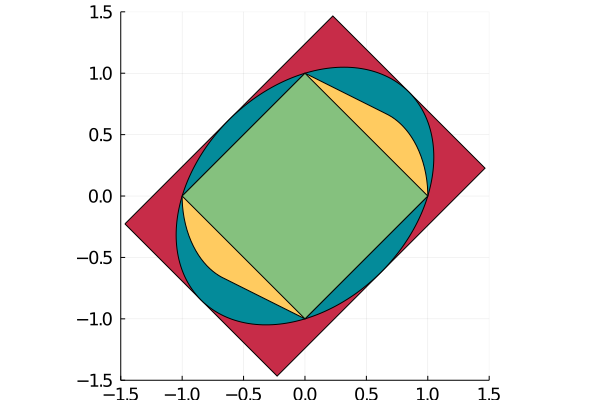

In [6]:
function polar_plot(set, γ; npoints=256, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), args...)
    plot(ratio=:equal, tickfont=Plots.font(12); xlim=xlim, ylim=ylim, args...)
    γ === nothing || plot!(inv(γ) * outer, color=frambo)
    plot!(polar(set), color=canard, npoints=npoints)
    plot!(polar_mci, color=aurore)
    plot!(polar(□_2), color=lichen)
end
polar_plot(project(sol_ell, 1:2), γ_ell)

## Polyset template

In [7]:
p4, γ4 = maximal_invariant(PolySet(symmetric=true, degree=4, convex=true), 0.91)
γ4

γ = 0.91
JuMP.objective_function(model) = 0.91
solve_time(model) = 0.07909107208251953
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.objective_value(model) = 0.91


0.91

Below is the primal plot:

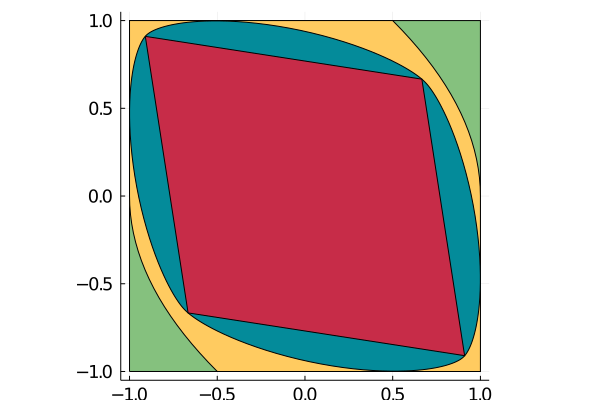

In [8]:
primal_plot(project(p4, 1:2), γ4)

and here is the polar plot:

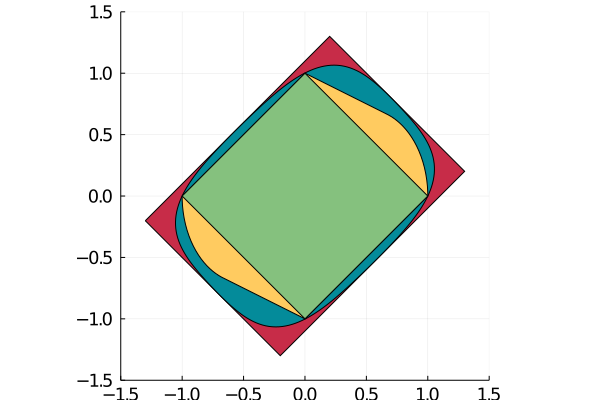

In [9]:
polar_plot(project(p4, 1:2), γ4)

## Piecewise semi-ellipsoidal template

In [10]:
sol_piece_◇, γ_piece_◇ = maximal_invariant(Ellipsoid(symmetric=true, piecewise=polar(□_3)), dirs=all_dirs)
γ_piece_◇

γ = γ
JuMP.objective_function(model) = γ
solve_time(model) = 2.0837697982788086
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.objective_value(model) = 0.894888954391664


0.894888954391664

Below is the primal plot:

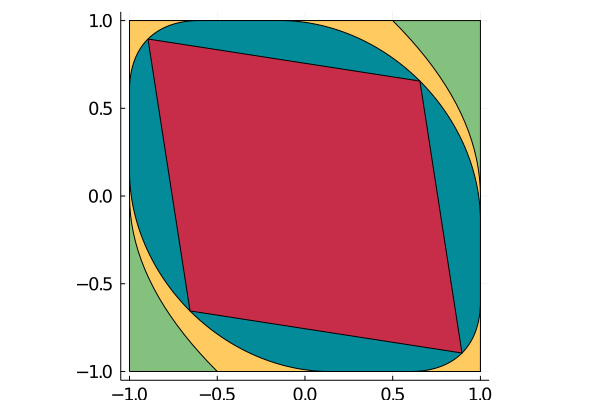

In [11]:
primal_plot(project(sol_piece_◇, 1:2), γ_piece_◇)

and here is the polar plot:

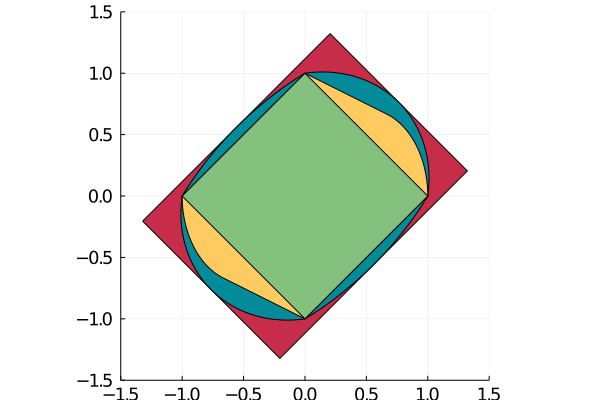

In [12]:
polar_plot(project(sol_piece_◇, 1:2), γ_piece_◇)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*